In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import SGD, Adam
from tensorflow.keras.optimizers import SGD
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [2]:
word_dict = {
    0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H',8:'I',9:'J',10:'K',11:'L',12:'M',13:'N',14:'O',15:'P',16:'Q',17:'R',18:'S',19:'T',20:'U',21:'V',22:'W',23:'X', 24:'Y',25:'Z'
}

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Tải EMNIST Letters
(ds_train_full, ds_test), ds_info = tfds.load(
    'emnist/letters',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# Xử lý ảnh phù hợp CNN
def pre_process(image, label):
    image = tf.transpose(image, perm=[1, 0, 2])        # Xoay ảnh về đúng chiều
    image = tf.cast(image, tf.float32) / 255.0         # Chuẩn hóa pixel về [0,1]
    label = label - 1                                   # Nhãn từ 1-26 → 0-25
    return image, label
# Áp dụng xử lý cho full train dataset
ds_train_full = ds_train_full.map(pre_process, num_parallel_calls=tf.data.AUTOTUNE)

# Tách ra validation set (10% train) bằng cách lấy phần đầu làm val, phần sau làm train
val_size = int(0.1 * ds_info.splits['train'].num_examples)

ds_val = ds_train_full.take(val_size).batch(128).prefetch(tf.data.AUTOTUNE)
ds_train = ds_train_full.skip(val_size).batch(128).prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(pre_process).batch(128).prefetch(tf.data.AUTOTUNE)


In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(26, activation='softmax')
])


model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 26)             │         6,682 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,274 (520.60 KB)

 Trainable params: 132,826 (518.85 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
model.fit(ds_train, validation_data=ds_test, epochs=10)
import matplotlib.pyplot as plt

class_names = [chr(i) for i in range(ord('a'), ord('z')+1)]

for images, labels in ds_test.take(1):
    preds = model.predict(images[:5])
    for i in range(5):
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        pred_label = class_names[tf.argmax(preds[i])]
        true_label = class_names[labels[i]]
        plt.title(f"Dự đoán: {pred_label}, Thật: {true_label}")
        plt.axis('off')
        plt.show()
model.save("du_doan_chu.h5")


In [2]:
def pre_process_image2(img):
    """
    Tiền xử lý ảnh để chuẩn bị cho việc nhận diện chữ số/chữ cái
    Tối ưu cho ảnh scan/photocopy có nền trắng và chữ đen
    """
    # Tạo bản copy để không thay đổi ảnh gốc
    img_copy = img.copy()
    
    # Kiểm tra nếu ảnh là màu thì chuyển về grayscale
    if len(img_copy.shape) == 3:
        img_copy = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
    
    # Áp dụng Gaussian blur nhẹ để giảm noise
    img_copy = cv2.GaussianBlur(img_copy, (3, 3), 0)
    
    # Sử dụng adaptive threshold thay vì OTSU cho ảnh scan
    # THRESH_BINARY (không phải INV) vì chữ đen trên nền trắng
    img_binary = cv2.adaptiveThreshold(
        img_copy, 
        255, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY_INV,  # INV để chữ trở thành trắng trên nền đen
        11, 
        2
    )
    
    # Áp dụng morphological operations để làm sạch
    kernel = np.ones((2,2), np.uint8)
    img_binary = cv2.morphologyEx(img_binary, cv2.MORPH_CLOSE, kernel)
    img_binary = cv2.morphologyEx(img_binary, cv2.MORPH_OPEN, kernel)
    
    # Tìm contour để crop chính xác vùng chứa chữ
    contours, _ = cv2.findContours(img_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        # Lọc các contour có diện tích quá nhỏ
        valid_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 10]
        
        if valid_contours:
            # Tìm bounding box chung của tất cả contours hợp lệ
            all_points = np.vstack([cnt.reshape(-1, 2) for cnt in valid_contours])
            x, y, w, h = cv2.boundingRect(all_points)
            
            # Crop vùng chứa chữ với một chút margin
            margin = 2
            x1 = max(0, x - margin)
            y1 = max(0, y - margin)
            x2 = min(img_binary.shape[1], x + w + margin)
            y2 = min(img_binary.shape[0], y + h + margin)
            
            digit_img = img_binary[y1:y2, x1:x2]
        else:
            digit_img = img_binary
    else:
        digit_img = img_binary
    
    # Kiểm tra nếu ảnh quá nhỏ hoặc trống
    if digit_img.shape[0] < 3 or digit_img.shape[1] < 3:
        # Tạo ảnh trống 28x28
        digit_img = np.zeros((28, 28), dtype=np.float32)
        return digit_img
    
    # Thêm padding để tạo khoảng trắng xung quanh chữ
    # Tính toán padding để tạo ảnh vuông
    h, w = digit_img.shape
    if h > w:
        pad_w = (h - w) // 2
        pad_h = 4
        digit_img = cv2.copyMakeBorder(digit_img, pad_h, pad_h, pad_w, pad_w + (h - w) % 2, 
                                       cv2.BORDER_CONSTANT, value=0)
    else:
        pad_h = (w - h) // 2
        pad_w = 4
        digit_img = cv2.copyMakeBorder(digit_img, pad_h, pad_h + (w - h) % 2, pad_w, pad_w, 
                                       cv2.BORDER_CONSTANT, value=0)
    
    # Resize về 28x28 với interpolation phù hợp
    digit_img = cv2.resize(digit_img, (28, 28), interpolation=cv2.INTER_AREA)
    
    # Normalize pixel values về [0, 1]
    digit_img = digit_img.astype(np.float32) / 255.0
    
    return digit_img


In [1]:
def predict2(image_array, model):
    """
    Dự đoán ký tự A, B, C, D từ ảnh đã được tiền xử lý
    
    Args:
        image_array: Ảnh đã được tiền xử lý (28x28) hoặc (1, 28, 28) hoặc (28, 28, 1)
        model: Model đã được train
    
    Returns:
        predicted_char: Ký tự dự đoán ('A', 'B', 'C', 'D' hoặc 'EMPTY')
    """
    
    # Chuẩn hóa shape của ảnh đầu vào
    if len(image_array.shape) == 2:  # (28, 28)
        image_input = image_array.reshape(1, 28, 28, 1)
    elif len(image_array.shape) == 3:  # (28, 28, 1) hoặc (1, 28, 28)
        if image_array.shape[0] == 1:  # (1, 28, 28)
            image_input = image_array.reshape(1, 28, 28, 1)
        else:  # (28, 28, 1)
            image_input = image_array.reshape(1, 28, 28, 1)
    elif len(image_array.shape) == 4:  # (1, 28, 28, 1)
        image_input = image_array
    else:
        raise ValueError(f"Unsupported image shape: {image_array.shape}")
    
    # Kiểm tra nếu ảnh quá trống (ít pixel khác 0)
    non_zero_pixels = np.count_nonzero(image_array)
    total_pixels = image_array.size
    
    if non_zero_pixels < total_pixels * 0.02:  # Nếu ít hơn 2% pixel có giá trị
        print("Ảnh quá trống, không thể nhận diện")
        return 'EMPTY'
    
    try:
        # Dự đoán từ model
        predictions = model.predict(image_input, verbose=0)
        
        # Tùy thuộc vào loại model, có thể cần điều chỉnh mapping
        # Option 1: Nếu model của bạn được train với labels 0,1,2,3 cho A,B,C,D
        if predictions.shape[1] == 4:  # Model chỉ có 4 classes (A,B,C,D)
            class_labels = ['A', 'B', 'C', 'D']
            predicted_index = np.argmax(predictions[0])
            predicted_char = class_labels[predicted_index]
            confidence = predictions[0][predicted_index]
            
        # Option 2: Nếu model là EMNIST với 26 classes (A-Z)
        elif predictions.shape[1] >= 26:
            # EMNIST mapping: A=0, B=1, C=2, D=3, ...
            limit_letters = [0, 1, 2, 3]  # Indices cho A, B, C, D
            limited_probs = predictions[0][limit_letters]
            best_index_in_limited = np.argmax(limited_probs)
            predicted_index = limit_letters[best_index_in_limited]
            predicted_char = chr(predicted_index + ord('A'))
            confidence = limited_probs[best_index_in_limited]
            
        # Option 3: Model khác (tự điều chỉnh)
        else:
            # Giả sử model có output khác, cần mapping riêng
            predicted_index = np.argmax(predictions[0])
            # Thêm logic mapping tùy theo model của bạn
            if predicted_index < 4:
                predicted_char = chr(predicted_index + ord('A'))
                confidence = predictions[0][predicted_index]
            else:
                predicted_char = 'UNKNOWN'
                confidence = 0.0
        
        # Kiểm tra confidence threshold
        if confidence < 0.3:  # Nếu độ tin cậy quá thấp
            predicted_char = 'UNCERTAIN'
        
        # Hiển thị kết quả (có thể comment để tăng tốc độ)
        plt.figure(figsize=(6, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(image_array.squeeze(), cmap='gray')
        plt.title(f"Dự đoán: {predicted_char}\nConfidence: {confidence:.3f}")
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        if predictions.shape[1] == 4:
            labels = ['A', 'B', 'C', 'D']
            plt.bar(labels, predictions[0])
        else:
            plt.bar(['A', 'B', 'C', 'D'], limited_probs)
        plt.title('Confidence Scores')
        plt.ylabel('Probability')
        plt.tight_layout()
        plt.show()
        
        return predicted_char
        
    except Exception as e:
        print(f"Lỗi trong quá trình dự đoán: {e}")
        return 'ERROR'

Xử lí ảnh import vào


=== Xử lý Cell 0 ===
Processed image shape: (28, 28)
Pixel value range: [0.000, 1.000]
Non-zero pixels: 144/784


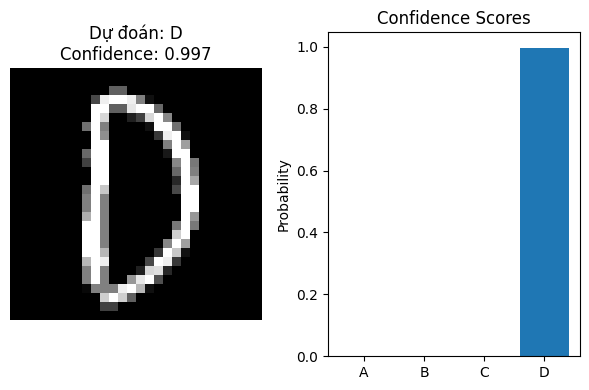

--> Đã nhận diện: D - Cell 0
------------------------------------------------------------

=== Xử lý Cell 1 ===
Processed image shape: (28, 28)
Pixel value range: [0.000, 1.000]
Non-zero pixels: 192/784


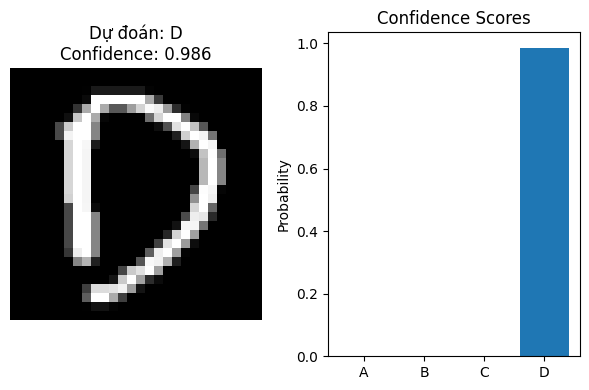

--> Đã nhận diện: D - Cell 1
------------------------------------------------------------

=== Xử lý Cell 2 ===
Processed image shape: (28, 28)
Pixel value range: [0.000, 1.000]
Non-zero pixels: 228/784


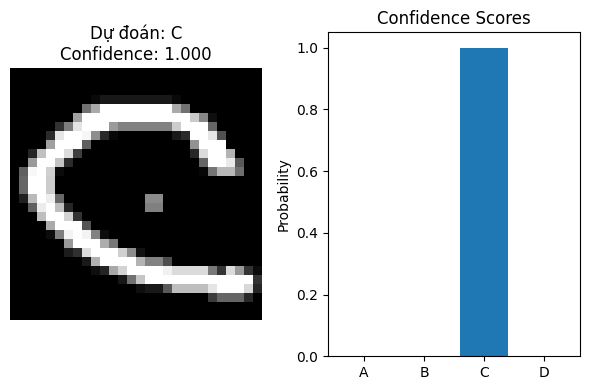

--> Đã nhận diện: C - Cell 2
------------------------------------------------------------

=== Xử lý Cell 3 ===
Không tìm thấy ký tự rõ ràng trong Cell 3, xử lý toàn bộ cell
Processed image shape: (28, 28)
Pixel value range: [0.000, 0.188]
Non-zero pixels: 56/784


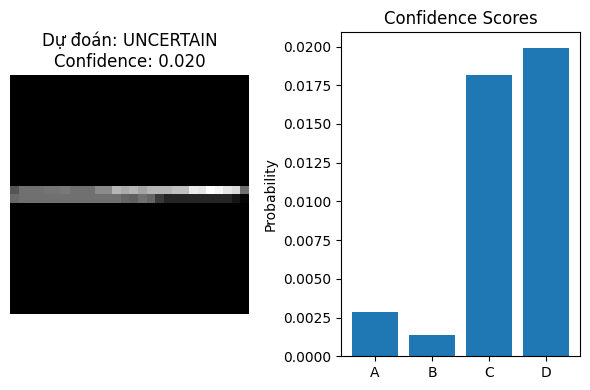

--> Đã nhận diện: UNCERTAIN - Cell 3
------------------------------------------------------------

=== Xử lý Cell 4 ===
Processed image shape: (28, 28)
Pixel value range: [0.000, 1.000]
Non-zero pixels: 175/784


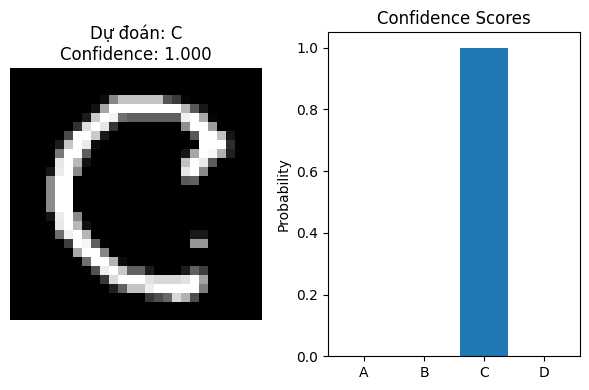

--> Đã nhận diện: C - Cell 4
------------------------------------------------------------

=== Xử lý Cell 5 ===
Processed image shape: (28, 28)
Pixel value range: [0.000, 1.000]
Non-zero pixels: 200/784


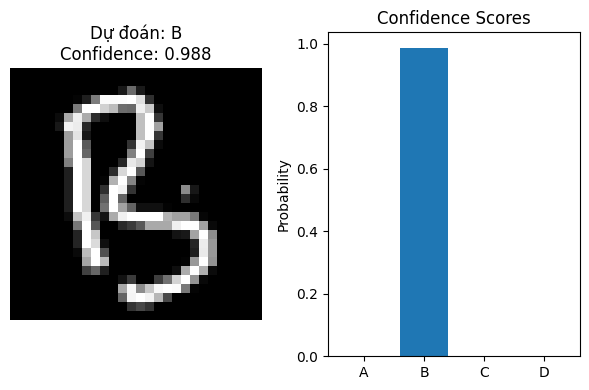

--> Đã nhận diện: B - Cell 5
------------------------------------------------------------

=== Xử lý Cell 6 ===
Không tìm thấy ký tự rõ ràng trong Cell 6, xử lý toàn bộ cell
Processed image shape: (28, 28)
Pixel value range: [0.000, 0.149]
Non-zero pixels: 49/784


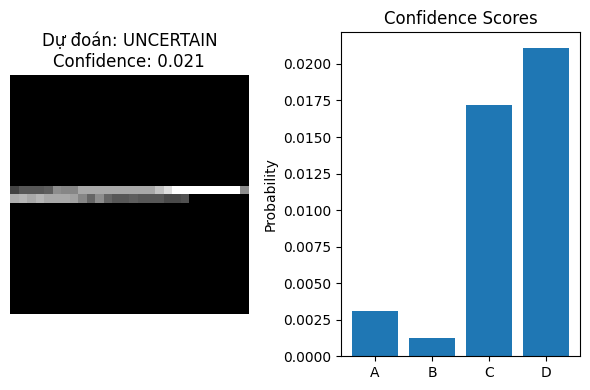

--> Đã nhận diện: UNCERTAIN - Cell 6
------------------------------------------------------------

=== Xử lý Cell 7 ===
Không tìm thấy ký tự rõ ràng trong Cell 7, xử lý toàn bộ cell
Processed image shape: (28, 28)
Pixel value range: [0.000, 0.145]
Non-zero pixels: 54/784


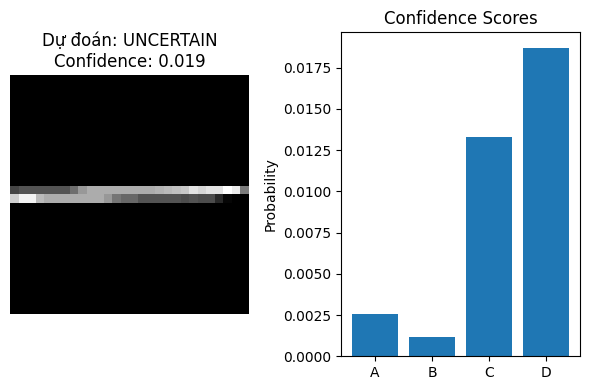

--> Đã nhận diện: UNCERTAIN - Cell 7
------------------------------------------------------------

=== Xử lý Cell 8 ===
Không tìm thấy ký tự rõ ràng trong Cell 8, xử lý toàn bộ cell
Processed image shape: (28, 28)
Pixel value range: [0.000, 0.145]
Non-zero pixels: 44/784


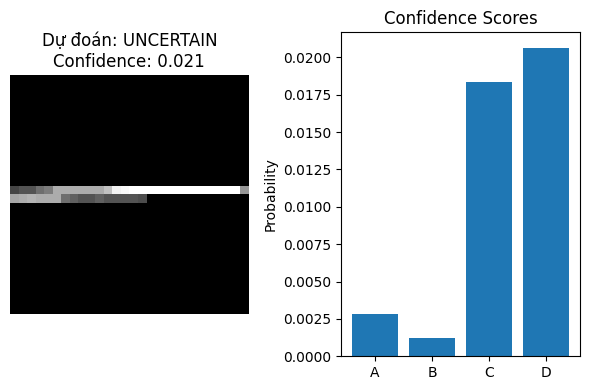

--> Đã nhận diện: UNCERTAIN - Cell 8
------------------------------------------------------------

=== Xử lý Cell 9 ===
Processed image shape: (28, 28)
Pixel value range: [0.000, 1.000]
Non-zero pixels: 149/784


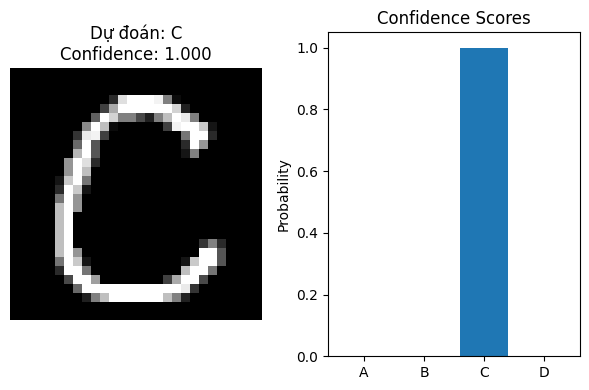

--> Đã nhận diện: C - Cell 9
------------------------------------------------------------

=== Xử lý Cell 10 ===
Không tìm thấy ký tự rõ ràng trong Cell 10, xử lý toàn bộ cell
Processed image shape: (28, 28)
Pixel value range: [0.000, 0.145]
Non-zero pixels: 55/784


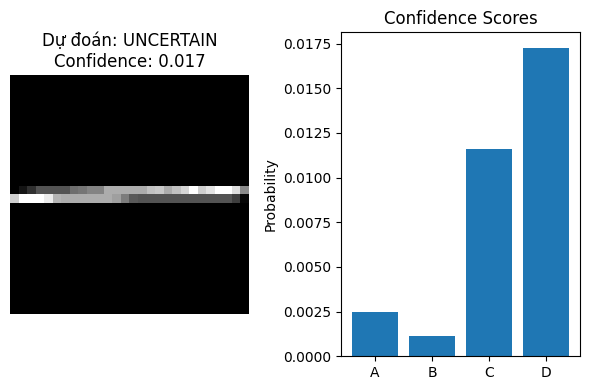

--> Đã nhận diện: UNCERTAIN - Cell 10
------------------------------------------------------------

=== Xử lý Cell 11 ===
Processed image shape: (28, 28)
Pixel value range: [0.000, 1.000]
Non-zero pixels: 170/784


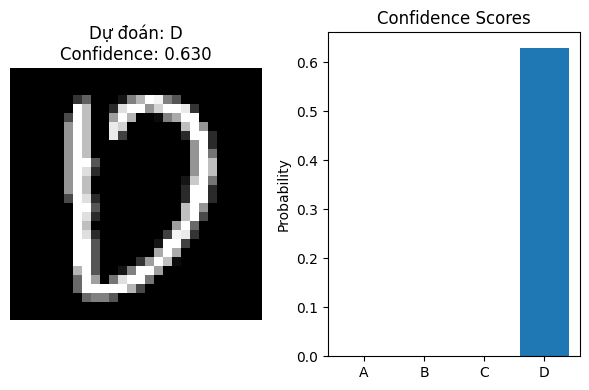

--> Đã nhận diện: D - Cell 11
------------------------------------------------------------

=== Xử lý Cell 12 ===
Không tìm thấy ký tự rõ ràng trong Cell 12, xử lý toàn bộ cell
Processed image shape: (28, 28)
Pixel value range: [0.000, 0.184]
Non-zero pixels: 41/784


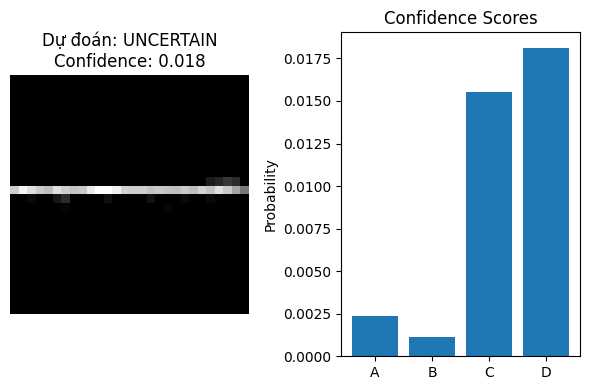

--> Đã nhận diện: UNCERTAIN - Cell 12
------------------------------------------------------------

=== Xử lý Cell 13 ===
Không tìm thấy ký tự rõ ràng trong Cell 13, xử lý toàn bộ cell
Processed image shape: (28, 28)
Pixel value range: [0.000, 0.137]
Non-zero pixels: 56/784


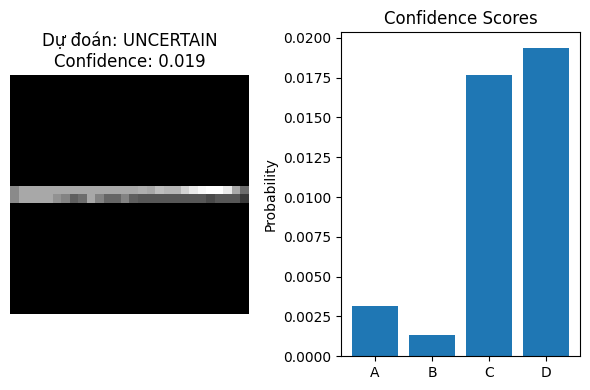

--> Đã nhận diện: UNCERTAIN - Cell 13
------------------------------------------------------------

=== Xử lý Cell 14 ===
Không tìm thấy ký tự rõ ràng trong Cell 14, xử lý toàn bộ cell
Processed image shape: (28, 28)
Pixel value range: [0.000, 0.188]
Non-zero pixels: 56/784


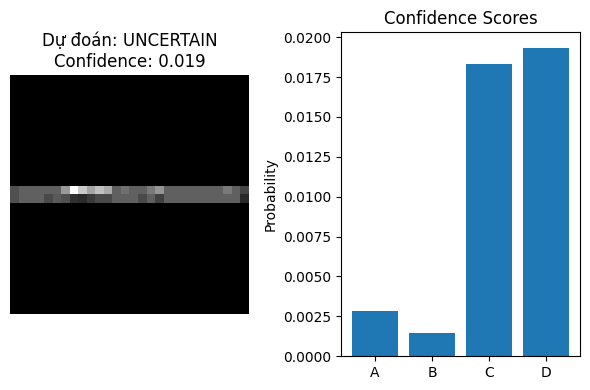

--> Đã nhận diện: UNCERTAIN - Cell 14
------------------------------------------------------------

=== Xử lý Cell 15 ===
Processed image shape: (28, 28)
Pixel value range: [0.000, 1.000]
Non-zero pixels: 176/784


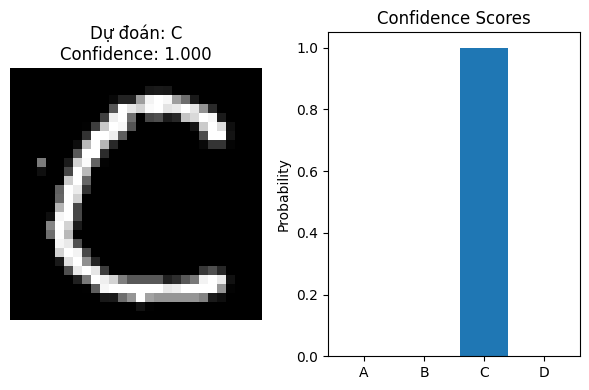

--> Đã nhận diện: C - Cell 15
------------------------------------------------------------

=== Xử lý Cell 16 ===
Processed image shape: (28, 28)
Pixel value range: [0.000, 1.000]
Non-zero pixels: 181/784


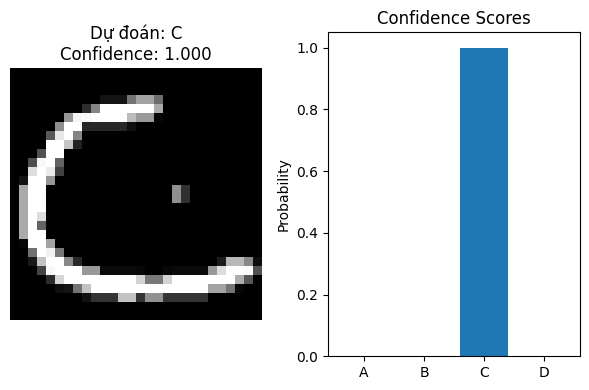

--> Đã nhận diện: C - Cell 16
------------------------------------------------------------

=== Xử lý Cell 17 ===
Processed image shape: (28, 28)
Pixel value range: [0.000, 1.000]
Non-zero pixels: 181/784


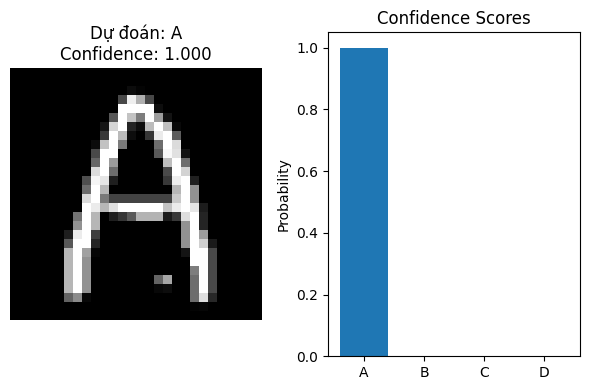

--> Đã nhận diện: A - Cell 17
------------------------------------------------------------

=== Xử lý Cell 18 ===
Processed image shape: (28, 28)
Pixel value range: [0.000, 1.000]
Non-zero pixels: 209/784


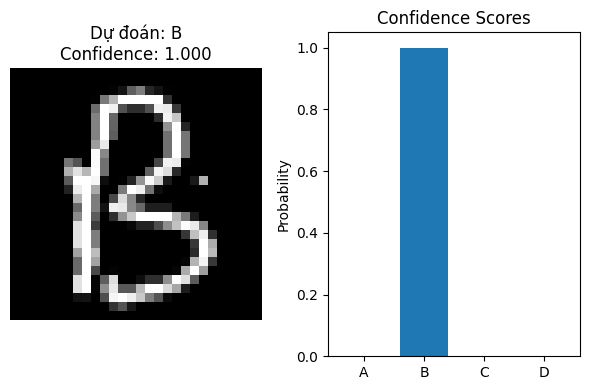

--> Đã nhận diện: B - Cell 18
------------------------------------------------------------

=== Xử lý Cell 19 ===
Processed image shape: (28, 28)
Pixel value range: [0.000, 1.000]
Non-zero pixels: 182/784


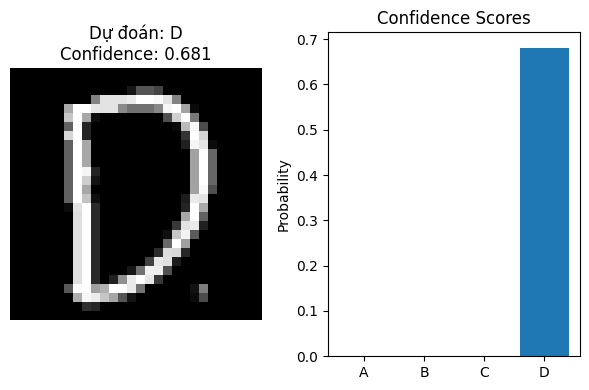

--> Đã nhận diện: D - Cell 19
------------------------------------------------------------

=== Xử lý Cell 20 ===
Processed image shape: (28, 28)
Pixel value range: [0.000, 1.000]
Non-zero pixels: 178/784


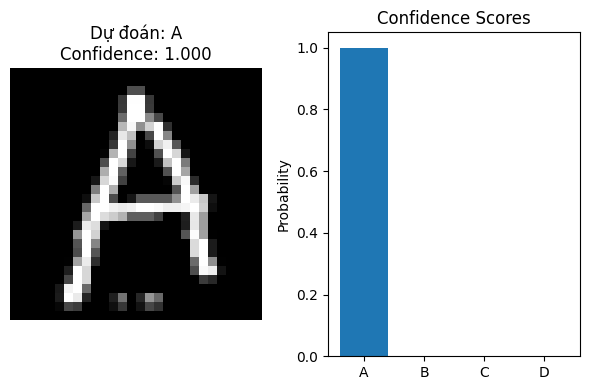

--> Đã nhận diện: A - Cell 20
------------------------------------------------------------

=== Xử lý Cell 21 ===
Processed image shape: (28, 28)
Pixel value range: [0.000, 1.000]
Non-zero pixels: 166/784


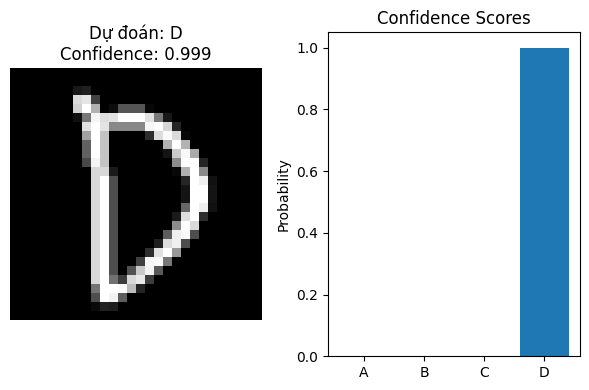

--> Đã nhận diện: D - Cell 21
------------------------------------------------------------

=== Xử lý Cell 22 ===
Processed image shape: (28, 28)
Pixel value range: [0.000, 1.000]
Non-zero pixels: 193/784


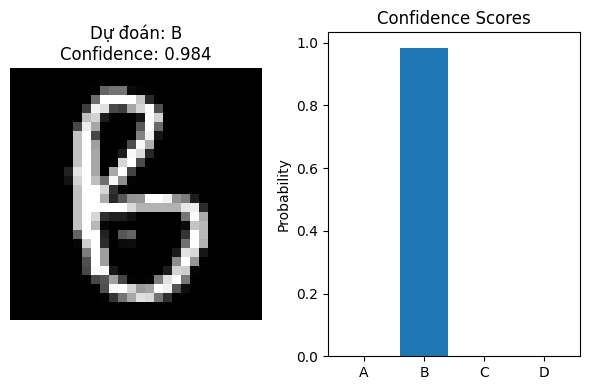

--> Đã nhận diện: B - Cell 22
------------------------------------------------------------

=== Xử lý Cell 23 ===
Processed image shape: (28, 28)
Pixel value range: [0.000, 1.000]
Non-zero pixels: 182/784


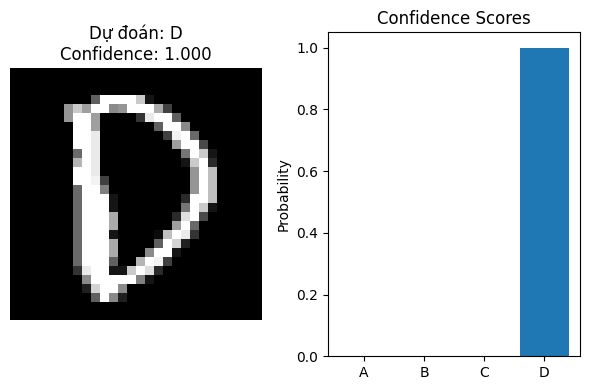

--> Đã nhận diện: D - Cell 23
------------------------------------------------------------

=== Xử lý Cell 24 ===
Processed image shape: (28, 28)
Pixel value range: [0.000, 1.000]
Non-zero pixels: 144/784


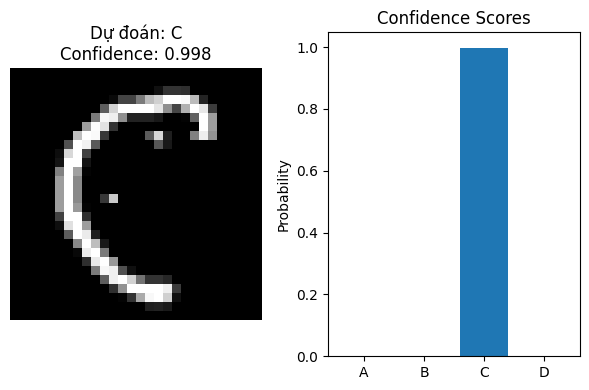

--> Đã nhận diện: C - Cell 24
------------------------------------------------------------

=== Xử lý Cell 25 ===
Processed image shape: (28, 28)
Pixel value range: [0.000, 1.000]
Non-zero pixels: 200/784


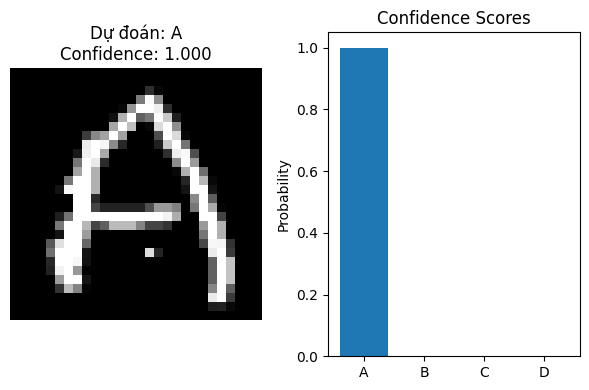

--> Đã nhận diện: A - Cell 25
------------------------------------------------------------

=== Xử lý Cell 26 ===
Processed image shape: (28, 28)
Pixel value range: [0.000, 1.000]
Non-zero pixels: 202/784


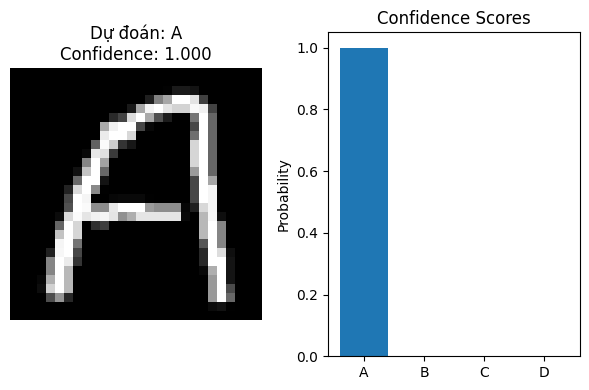

--> Đã nhận diện: A - Cell 26
------------------------------------------------------------

=== Xử lý Cell 27 ===
Processed image shape: (28, 28)
Pixel value range: [0.000, 1.000]
Non-zero pixels: 169/784


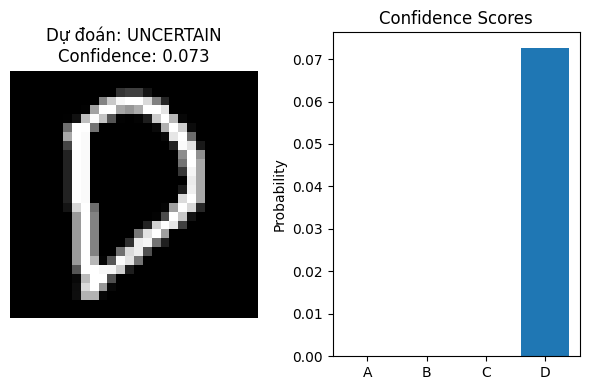

--> Đã nhận diện: UNCERTAIN - Cell 27
------------------------------------------------------------

=== Xử lý Cell 28 ===
Processed image shape: (28, 28)
Pixel value range: [0.000, 1.000]
Non-zero pixels: 181/784


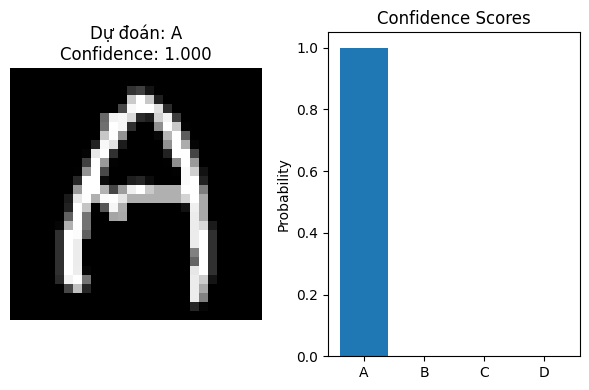

--> Đã nhận diện: A - Cell 28
------------------------------------------------------------

=== Xử lý Cell 29 ===
Processed image shape: (28, 28)
Pixel value range: [0.000, 1.000]
Non-zero pixels: 154/784


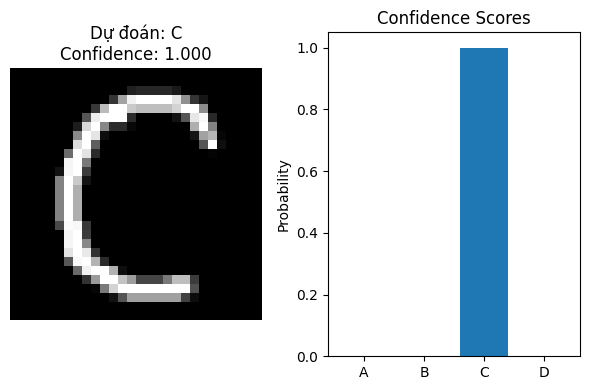

--> Đã nhận diện: C - Cell 29
------------------------------------------------------------

=== Xử lý Cell 30 ===
Processed image shape: (28, 28)
Pixel value range: [0.000, 1.000]
Non-zero pixels: 193/784


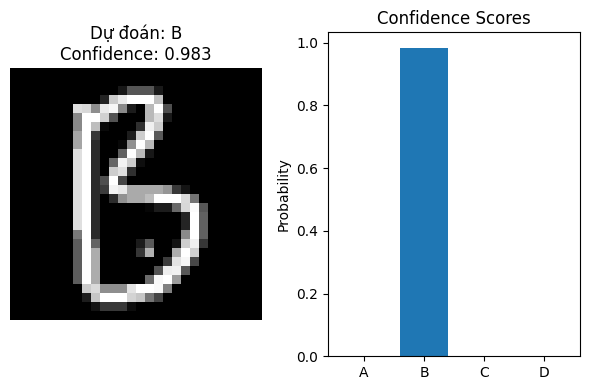

--> Đã nhận diện: B - Cell 30
------------------------------------------------------------

=== Xử lý Cell 31 ===
Processed image shape: (28, 28)
Pixel value range: [0.000, 1.000]
Non-zero pixels: 214/784


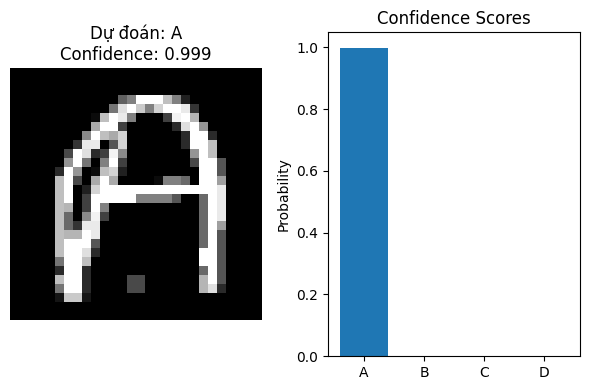

--> Đã nhận diện: A - Cell 31
------------------------------------------------------------

=== Xử lý Cell 32 ===
Không tìm thấy ký tự rõ ràng trong Cell 32, xử lý toàn bộ cell
Processed image shape: (28, 28)
Pixel value range: [0.000, 0.173]
Non-zero pixels: 53/784


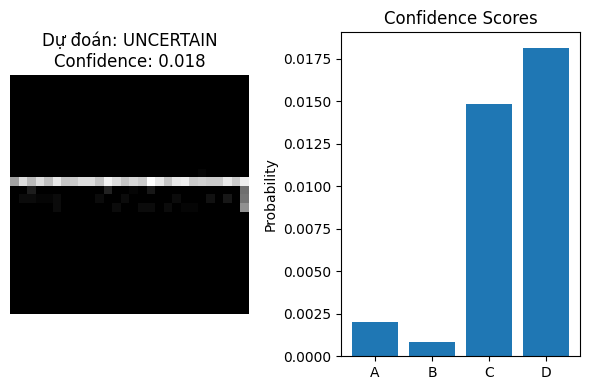

--> Đã nhận diện: UNCERTAIN - Cell 32
------------------------------------------------------------

=== Xử lý Cell 33 ===
Processed image shape: (28, 28)
Pixel value range: [0.000, 1.000]
Non-zero pixels: 184/784


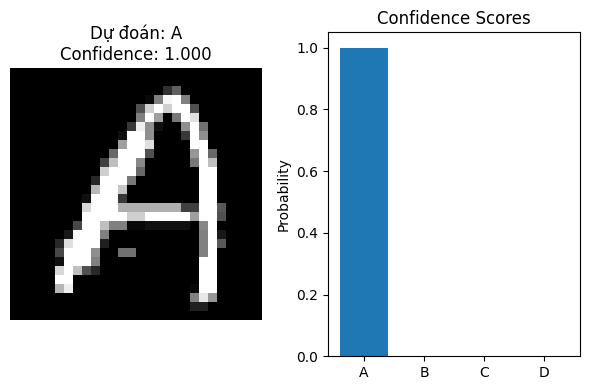

--> Đã nhận diện: A - Cell 33
------------------------------------------------------------

=== Xử lý Cell 34 ===
Processed image shape: (28, 28)
Pixel value range: [0.000, 1.000]
Non-zero pixels: 188/784


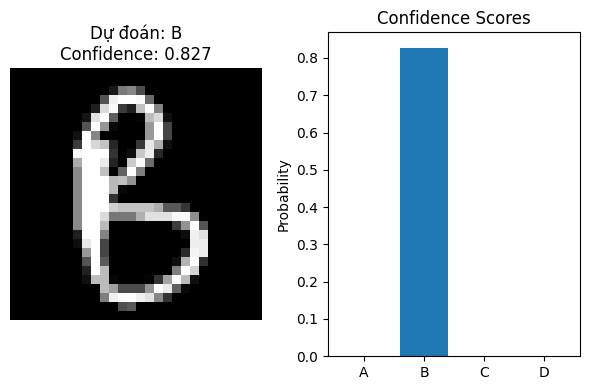

--> Đã nhận diện: B - Cell 34
------------------------------------------------------------

=== Xử lý Cell 35 ===
Không tìm thấy ký tự rõ ràng trong Cell 35, xử lý toàn bộ cell
Processed image shape: (28, 28)
Pixel value range: [0.000, 0.212]
Non-zero pixels: 114/784


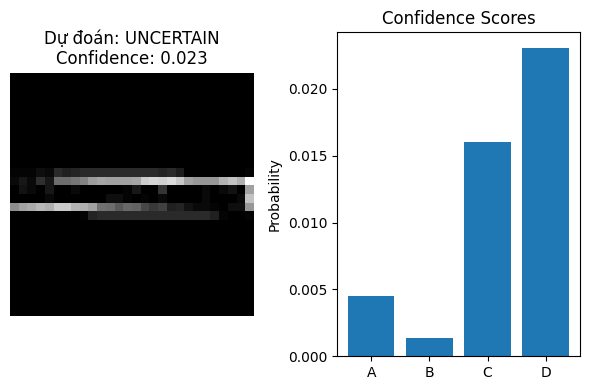

--> Đã nhận diện: UNCERTAIN - Cell 35
------------------------------------------------------------
Tổng số chữ số được trích xuất: 36
Kết quả nhận diện: ['D', 'D', 'C', 'UNCERTAIN', 'C', 'B', 'UNCERTAIN', 'UNCERTAIN', 'UNCERTAIN', 'C', 'UNCERTAIN', 'D', 'UNCERTAIN', 'UNCERTAIN', 'UNCERTAIN', 'C', 'C', 'A', 'B', 'D', 'A', 'D', 'B', 'D', 'C', 'A', 'A', 'UNCERTAIN', 'A', 'C', 'B', 'A', 'UNCERTAIN', 'A', 'B', 'UNCERTAIN']


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model


def load_and_preprocess_image(image_path):
    """
    Tải và tiền xử lý ảnh đầu vào
    """
    img = cv2.imread(image_path, 0)
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    thresh = cv2.adaptiveThreshold(
        blur,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        11,
        2
    )
    return img, thresh


def detect_table_structure(img, thresh):
    """
    Phát hiện cấu trúc bảng bằng morphological operations
    """
    horizal = thresh.copy()
    vertical = thresh.copy()

    scale_height = 15
    scale_long = 15

    long = int(img.shape[1] / scale_long)
    height = int(img.shape[0] / scale_height)

    # Tạo structural elements cho đường ngang
    horizalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (long, 1))
    horizal = cv2.erode(horizal, horizalStructure)
    horizal = cv2.dilate(horizal, horizalStructure)

    # Tạo structural elements cho đường dọc
    verticalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (1, height))
    vertical = cv2.erode(vertical, verticalStructure)
    vertical = cv2.dilate(vertical, verticalStructure)

    # Tạo mask tổng hợp
    mask = cv2.bitwise_or(vertical, horizal)
    
    return mask


def find_largest_table(mask):
    """
    Tìm bảng có diện tích lớn nhất trong ảnh
    """
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    max_area = 0
    x_max, y_max, w_max, h_max = 0, 0, 0, 0
    
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > max_area:
            x, y, w, h = cv2.boundingRect(cnt)
            x_max, y_max, w_max, h_max = x, y, w, h
            max_area = area
    
    return x_max, y_max, w_max, h_max


def extract_table_cells(img, thresh, x_max, y_max, w_max, h_max, num_rows=19, start_row=1):
    """
    Trích xuất các ô từ bảng đã được phát hiện
    """
    cropped_thresh_img = []
    cropped_origin_img = []
    contours_img = []
    
    # Trích xuất các ô từ cột đầu tiên
    for i in range(start_row, num_rows):
        row_start = y_max + round(i * h_max / num_rows)
        row_end = y_max + round((i + 1) * h_max / num_rows)
        col_start = x_max + round(w_max / 6)
        col_end = x_max + round(w_max / 2)
        
        thresh1 = thresh[row_start:row_end, col_start:col_end]
        contours_thresh1, _ = cv2.findContours(thresh1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        origin1 = img[row_start:row_end, col_start:col_end]

        cropped_thresh_img.append(thresh1)
        cropped_origin_img.append(origin1)
        contours_img.append(contours_thresh1)

    # Trích xuất các ô từ cột thứ hai
    for i in range(start_row, num_rows):
        row_start = y_max + round(i * h_max / num_rows)
        row_end = y_max + round((i + 1) * h_max / num_rows)
        col_start = x_max + round(2 * w_max / 3)
        col_end = x_max + round(w_max)
        
        thresh1 = thresh[row_start:row_end, col_start:col_end]
        contours_thresh1, _ = cv2.findContours(thresh1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        origin1 = img[row_start:row_end, col_start:col_end]

        cropped_thresh_img.append(thresh1)
        cropped_origin_img.append(origin1)
        contours_img.append(contours_thresh1)
    
    return cropped_thresh_img, cropped_origin_img, contours_img


def extract_character_from_cell(cell_img, contours):
    """
    Trích xuất ký tự từ một ô cụ thể
    """
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 20:
            x, y, w, h = cv2.boundingRect(cnt)
            
            img_height, img_width = cell_img.shape
            
            # Kiểm tra vị trí và kích thước hợp lý
            if (w > 3 and h > 3 and
                x > img_width * 0.02 and x < img_width * 0.98 and
                y > img_height * 0.02 and y < img_height * 0.98):
                
                # Trích xuất vùng chứa ký tự với margin
                margin = 2
                x1 = max(0, x - margin)
                y1 = max(0, y - margin) 
                x2 = min(img_width, x + w + margin)
                y2 = min(img_height, y + h + margin)
                
                character_img = cell_img[y1:y2, x1:x2]
                
                if character_img.shape[0] > 3 and character_img.shape[1] > 3:
                    return character_img
    
    return None


def visualize_cell_processing(cell_idx, original_img, thresh_img, cropped_char, processed_img):
    """
    Hiển thị quá trình xử lý của một ô
    """
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 4, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title(f'Original Cell {cell_idx}')
    plt.axis('off')
    
    plt.subplot(1, 4, 2)
    plt.imshow(thresh_img, cmap='gray')
    plt.title(f'Threshold Cell {cell_idx}')
    plt.axis('off')
    
    if cropped_char is not None:
        plt.subplot(1, 4, 3)
        plt.imshow(cropped_char, cmap='gray')
        plt.title(f'Cropped Cell {cell_idx}')
        plt.axis('off')
    
    plt.subplot(1, 4, 4)
    plt.imshow(processed_img, cmap='gray')
    plt.title(f'Processed Cell {cell_idx}')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


def process_all_cells(cropped_thresh_img, cropped_origin_img, contours_img, model):
    """
    Phiên bản đã sửa của process_all_cells
    """
    results = []
    
    for i, contour_img in enumerate(contours_img):
        print(f"\n=== Xử lý Cell {i} ===")
        
        try:
            # Trích xuất ký tự từ ô
            character_img = extract_character_from_cell(cropped_origin_img[i], contour_img)
            
            # Nếu không tìm thấy ký tự rõ ràng, sử dụng toàn bộ ô
            if character_img is None:
                print(f"Không tìm thấy ký tự rõ ràng trong Cell {i}, xử lý toàn bộ cell")
                character_img = cropped_origin_img[i]
            
            # Tiền xử lý ảnh
            processed_img = pre_process_image2(character_img)
            
            # In thông tin chi tiết
            print(f"Processed image shape: {processed_img.shape}")
            print(f"Pixel value range: [{processed_img.min():.3f}, {processed_img.max():.3f}]")
            print(f"Non-zero pixels: {np.count_nonzero(processed_img)}/{processed_img.size}")
            
            # Dự đoán với function đã fix
            if np.count_nonzero(processed_img) > 5:  # Giảm threshold từ 10 xuống 5
                char = predict2(processed_img, model)
                results.append(char)
                print(f"--> Đã nhận diện: {char} - Cell {i}")
            else:
                results.append("EMPTY")
                print(f"--> Cell trống - Cell {i}")
            
        except Exception as e:
            print(f"Lỗi xử lý Cell {i}: {e}")
            import traceback
            traceback.print_exc()
            results.append("ERROR")
        
        print("-" * 60)
    
    return results

def main():
    """
    Hàm chính thực hiện toàn bộ quy trình
    """
    # Tải và tiền xử lý ảnh
    img, thresh = load_and_preprocess_image("tn.jpg")
    
    # Phát hiện cấu trúc bảng
    mask = detect_table_structure(img, thresh)
    
    # Tìm bảng lớn nhất
    x_max, y_max, w_max, h_max = find_largest_table(mask)
    
    # Trích xuất bảng
    table = img[y_max:y_max+h_max, x_max:x_max+w_max]
    
    # Trích xuất các ô
    cropped_thresh_img, cropped_origin_img, contours_img = extract_table_cells(
        img, thresh, x_max, y_max, w_max, h_max
    )
    
    # Tải model
    model = load_model('emnist_cnn_model.h5')
    
    # Xử lý tất cả các ô và nhận diện
    results = process_all_cells(cropped_thresh_img, cropped_origin_img, contours_img, model)
    
    print(f"Tổng số chữ số được trích xuất: {len(results)}")
    print(f"Kết quả nhận diện: {results}")
    
    return results


if __name__ == "__main__":
    results = main()